# Image Analysis for datasets

This example notebook shows how to use datasetinsights to do image analysis on datasets

## Variance of Laplacian

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import os
from pycocotools.coco import COCO
from datasetinsights.stats.image_analysis import laplacian_img, get_bbox_var_laplacian, get_fg_bg_var_laplacian, get_img_var_laplacian


In [2]:
annotation_file_path = "<file-path>"
img_dir_path = "<img-dir-path>"

In [3]:
coco = COCO(annotation_file=annotation_file_path)
img_ids = coco.getImgIds(catIds=[1])

loading annotations into memory...
Done (t=8.66s)
creating index...
index created!


In [4]:
bg_vars, fg_vars = [], []

In [5]:
for img_id in tqdm(img_ids[:10000]):
    img_meta_data = coco.loadImgs(ids=[img_id])
    file_name = img_meta_data[0]['file_name']

    img_path = os.path.join(img_dir_path, file_name)
    laplacian = laplacian_img(img_path)

    ann_ids = coco.getAnnIds(imgIds=img_id)
    annotations = coco.loadAnns(ann_ids)
    bbox_var_lap, img_var_laplacian = get_fg_bg_var_laplacian(laplacian, annotations)

    bg_vars.append(img_var_laplacian)
    fg_vars.extend(bbox_var_lap)



  0%|                                                                                                                                                                                                         | 0/10000 [00:00<?, ?it/s]/Users/saurav.dhakad/unity/datasetinsights/datasetinsights/stats/image_analysis/laplacian.py:50: RuntimeWarning: Degrees of freedom <= 0 for slice.
  return np.nanvar(bbox_var)
  2%|████                                                                                                                                                                                           | 212/10000 [00:02<01:39, 97.96it/s]/Users/saurav.dhakad/unity/datasetinsights/datasetinsights/stats/image_analysis/laplacian.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice.
  img_var_laplacian = np.nanvar(img_laplacian)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

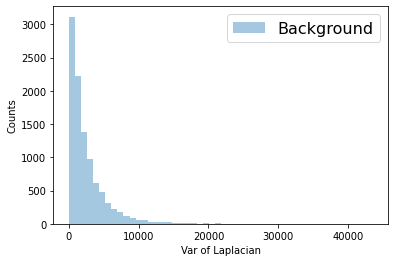

In [33]:
sns.distplot(bg_vars, hist = True, kde = False,
             kde_kws = {'linewidth': 3},
             label = "Background")
plt.legend(prop={'size': 16}, title = '')
plt.xlabel('Var of Laplacian')
plt.ylabel('Counts')
plt.show()

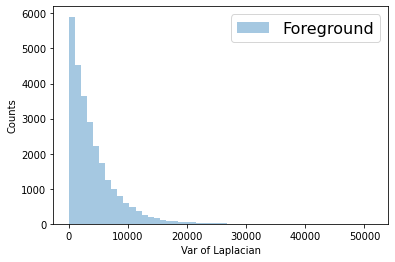

In [36]:
sns.distplot(fg_vars, hist = True, kde = False,
             kde_kws = {'linewidth': 3},
             label = "Foreground")
plt.legend(prop={'size': 16}, title = '')
plt.xlabel('Var of Laplacian')
plt.ylabel('Counts')
plt.show()